In [10]:
import yaml
import pandas as pd
from pathlib import Path

config_path = Path("../config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

csv_path = config["data"]["clean_data_csv"]["clean_data"]
csv_full_path = config_path.parent / csv_path

df = pd.read_csv(csv_full_path)
print("✅ Original shape:", df.shape)


✅ Original shape: (7566, 46)


In [3]:
# Power Transformation
#To address strong skewness in numerical features (e.g., `selling_price`, `engine`, `max_power`, `torque`),  
#we applied a **PowerTransformer**.  
#This technique symmetrizes the data distribution and reduces the impact of extreme values without losing information.  
#It helps the model learn more stable patterns, especially for regression tasks.

from sklearn.preprocessing import PowerTransformer

num_cols = ['selling_price','km_driven','engine','max_power','torque','mileage']
pt = PowerTransformer()
df[num_cols] = pt.fit_transform(df[num_cols])

print("✅ PowerTransformer applied successfully")


✅ PowerTransformer applied successfully


In [4]:
#Removing extreme outliers

Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

df = df[(df['selling_price'] >= lower_bound) & (df['selling_price'] <= upper_bound)]
print("✅ Shape after removing extreme outliers from target:", df.shape)


✅ Shape after removing extreme outliers from target: (7566, 46)


In [5]:
# === REAPPLY POWERTRANSFORMER AND MINMAXSCALER AFTER OUTLIER REMOVAL ===
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_cols = ['selling_price', 'km_driven', 'engine', 'max_power', 'torque', 'mileage']
cat_cols = [col for col in df.columns if col not in num_cols]

# Reapply PowerTransformer now that extreme outliers are removed
pt = PowerTransformer()
df[num_cols] = pt.fit_transform(df[num_cols])

# Scale only the numeric columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ PowerTransformer + MinMaxScaler applied successfully after outlier removal")
print("Shape:", df.shape)


✅ PowerTransformer + MinMaxScaler applied successfully after outlier removal
Shape: (7566, 46)


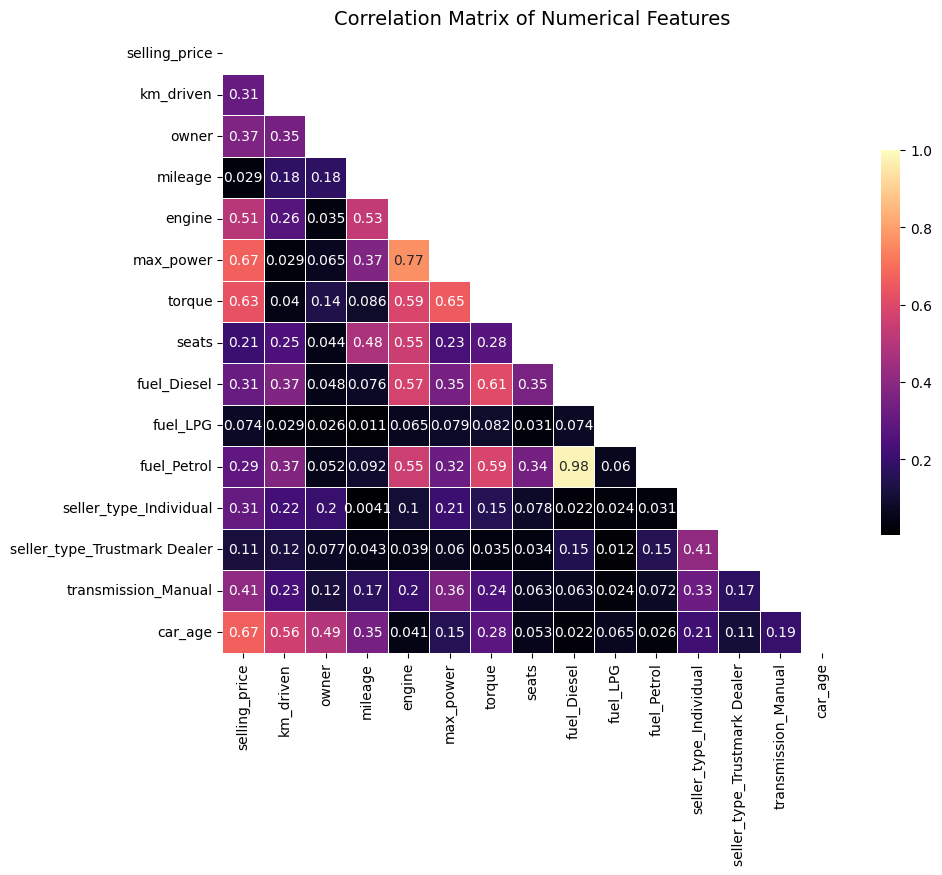

In [7]:
# === FEATURE CORRELATION ANALYSIS (FINAL CLEAN DATASET) ===

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Drop brand dummy columns to simplify visualization
df_corr = df.copy()
df_corr = df_corr.drop(columns=[
    'brand_Ashok','brand_Audi','brand_BMW','brand_Chevrolet','brand_Daewoo',
    'brand_Datsun','brand_Fiat','brand_Force','brand_Ford','brand_Honda',
    'brand_Hyundai','brand_Isuzu','brand_Jaguar','brand_Jeep','brand_Kia',
    'brand_Land','brand_Lexus','brand_MG','brand_Mahindra','brand_Maruti',
    'brand_Mercedes-Benz','brand_Mitsubishi','brand_Nissan','brand_Opel',
    'brand_Peugeot','brand_Renault','brand_Skoda','brand_Tata','brand_Toyota',
    'brand_Volkswagen','brand_Volvo'
])

# Calculate the absolute correlation matrix
corr = np.abs(df_corr.corr())

# Create a mask for the upper triangle (to avoid duplicate values)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask, cmap='magma', vmax=1, square=True, linewidths=.5,
            annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.show()


### Correlation Analysis and Feature Selection

After analyzing the correlation matrix of all numerical features, we observed moderate relationships between some variables 
(e.g., `max_power` and `engine`), but no correlations exceeded a critical threshold (0.85). 

Therefore, we decided **not to drop any features** at this stage, since all of them may still contribute useful information 
to the predictive models. Tree-based algorithms (e.g., Random Forest, Gradient Boosting) are also robust to multicollinearity, 
which supports this decision.

In [9]:
df.to_csv("../data/clean_data_csv/clean_data_v3_irma.csv", index=False)
print("Saved final cleaned and transformed dataset as clean_data_v3_irma.csv")



Saved final cleaned and transformed dataset as clean_data_v3_irma.csv
